In [1]:
import pandas as pd
from datasets import load_dataset

domain_worker_desires = load_dataset("SALT-NLP/WORKBank", data_files="worker_data/domain_worker_desires.csv")["train"].to_pandas()
expert_ratings = load_dataset("SALT-NLP/WORKBank", data_files="expert_ratings/expert_rated_technological_capability.csv")["train"].to_pandas()

desire_by_task = domain_worker_desires.groupby("Task")["Automation Desire Rating"].mean().rename("automation_desire")
capacity_by_task = expert_ratings.groupby("Task")["Automation Capacity Rating"].mean().rename("automation_capacity")

task_scores = pd.concat([desire_by_task, capacity_by_task], axis=1).dropna().reset_index()

In [2]:
# Compute correlation between automation capacity and desire
from scipy.stats import spearmanr

r_s, p_s = spearmanr(task_scores["automation_capacity"], task_scores["automation_desire"])
print(f"Spearman's rank correlation coefficient: {r_s:.4f}, p-value: {p_s}")

Spearman's rank correlation coefficient: 0.1654, p-value: 1.3467870134756003e-06


## Desire-Capability Quadrant Plot

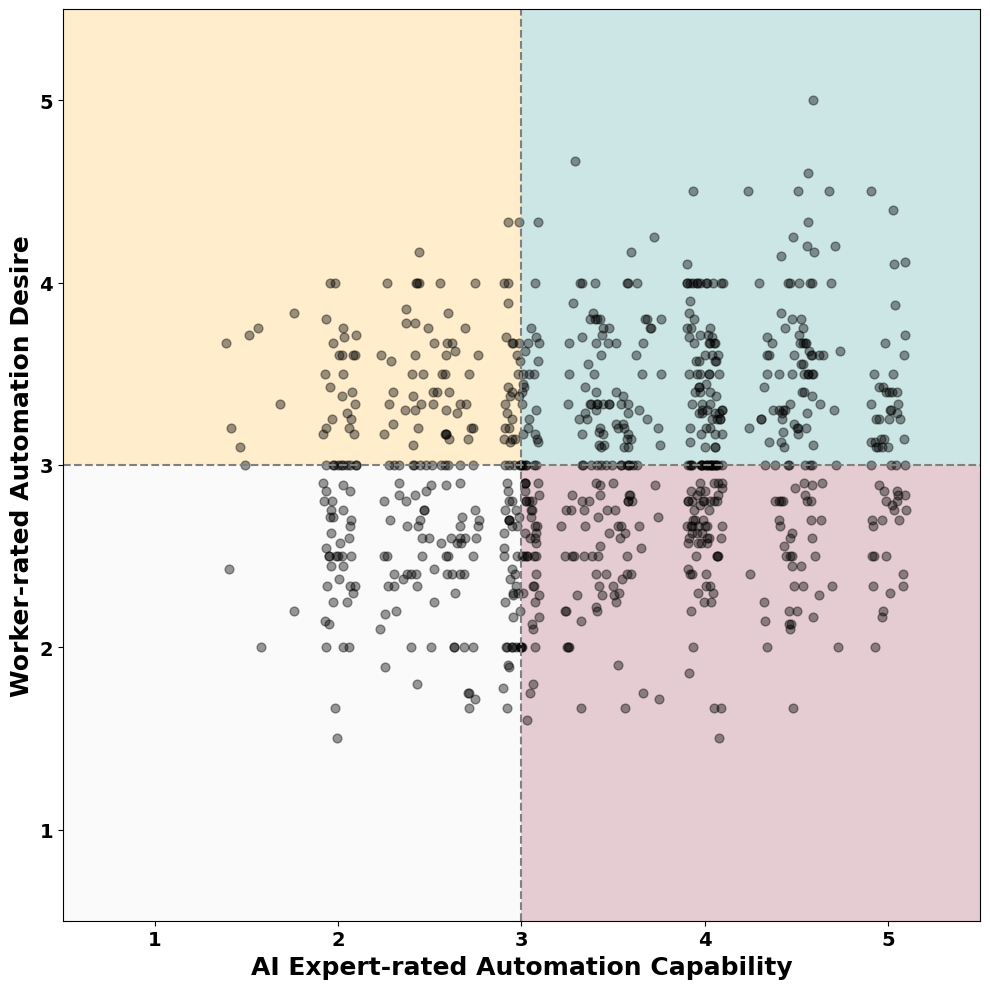

In [3]:
import matplotlib.pyplot as plt
import numpy as np


# control random seed for reproducibility
np.random.seed(42)

# Identify quadrant outliers
q1 = task_scores[(task_scores["automation_capacity"] >= 3.0) & (task_scores["automation_desire"] >= 3.0)]  # Top-right
q2 = task_scores[(task_scores["automation_capacity"] < 3.0) & (task_scores["automation_desire"] >= 3.0)]   # Top-left
q3 = task_scores[(task_scores["automation_capacity"] < 3.0) & (task_scores["automation_desire"] < 3.0)]    # Bottom-left
q4 = task_scores[(task_scores["automation_capacity"] >= 3.0) & (task_scores["automation_desire"] < 3.0)]   # Bottom-right

# Pick most extreme point in each quadrant
label_tasks = pd.concat([
    q1.loc[(q1["automation_capacity"] + q1["automation_desire"]).idxmax()],
    q2.loc[(q2["automation_desire"] - q2["automation_capacity"]).idxmax()],
    q3.loc[(q3["automation_capacity"] + q3["automation_desire"]).idxmin()],
    q4.loc[(q4["automation_capacity"] - q4["automation_desire"]).idxmax()],
], axis=1).T

# 4. Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Background shaded regions
plt.axvspan(0.5, 3, ymin=0, ymax=0.5, facecolor='#eaeaea', alpha=0.2)
plt.axvspan(3, 5.5, ymin=0, ymax=0.5, facecolor='#800020', alpha=0.2)
plt.axvspan(0.5, 3, ymin=0.5, ymax=1, facecolor='orange', alpha=0.2)
plt.axvspan(3, 5.5, ymin=0.5, facecolor='teal', alpha=0.2)

# -- STRIP PLOT instead of heatmap --
# Add slight jitter to x-values
task_scores['automation_capacity_jittered'] = task_scores['automation_capacity'] + np.random.uniform(-0.1, 0.1, size=len(task_scores))

# Scatter (strip) plot
plt.scatter(
    task_scores["automation_capacity_jittered"],
    task_scores["automation_desire"],
    color='black',
    s=40,
    alpha=0.4
)

# Quadrant lines at 3.0
plt.axhline(y=3.0, color='gray', linestyle='--')
plt.axvline(x=3.0, color='gray', linestyle='--')

# Labels and layout
plt.xlabel("AI Expert-rated Automation Capability", fontsize=18, fontweight='bold')
plt.ylabel("Worker-rated Automation Desire", fontsize=18, fontweight='bold')
plt.xticks(fontsize=14, fontweight='bold')
plt.yticks(fontsize=14, fontweight='bold')
plt.xlim(0.5, 5.5)
plt.ylim(0.5, 5.5)
plt.tight_layout()
plt.grid(False)  # Remove grid lines
fig.savefig("../local/automation_desire_vs_capacity.svg",
            format="svg",
            bbox_inches="tight")
plt.show()

In [4]:
# HTML version
import plotly.express as px


task_occupation_mapping = domain_worker_desires[["Task", "Occupation (O*NET-SOC Title)"]].drop_duplicates()
task_scores = task_scores.merge(task_occupation_mapping, on="Task", how="left")

# Plot with Plotly
fig = px.scatter(
    task_scores,
    x="automation_capacity_jittered",
    y="automation_desire",
    hover_data=["Task", "Occupation (O*NET-SOC Title)"],
    labels={
        "automation_capacity_jittered": "AI Expert-rated Automation Capability",
        "automation_desire": "Worker-rated Automation Desire"
    },
    opacity=0.5
)

# Add quadrant lines
fig.add_shape(type="line", x0=3, y0=0.5, x1=3, y1=5.5, line=dict(color="gray", dash="dash"))
fig.add_shape(type="line", x0=0.5, y0=3, x1=5.5, y1=3, line=dict(color="gray", dash="dash"))

# Update layout
fig.update_layout(
    title="Desire vs Capability Scatter Plot",
    width=900,
    height=700,
    xaxis_range=[0.5, 5.5],
    yaxis_range=[0.5, 5.5],
    xaxis=dict(title_font=dict(size=16), tickfont=dict(size=14)),
    yaxis=dict(title_font=dict(size=16), tickfont=dict(size=14)),
    plot_bgcolor='white'
)

# Save to HTML
fig.write_html("../local/desire_vs_capability_interactive.html")
fig.show()


In [5]:
import os


def plot_sector_landscape(sector, file_path=None):
    sector_filename = f"../external_data/onet_data/onet_sector/{sector.replace(' ', '_')}.csv"
    if not os.path.exists(sector_filename):
        raise FileNotFoundError(f"Sector file not found: {sector_filename}")
    
    sector_occupations = pd.read_csv(sector_filename)["Occupation"].unique()
    task_scores_sector = task_scores[task_scores["Occupation (O*NET-SOC Title)"].isin(sector_occupations)]
    
    # 4. Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Background shaded regions
    plt.axvspan(0.5, 3, ymin=0, ymax=0.5, facecolor='#eaeaea', alpha=0.2)
    plt.axvspan(3, 5.5, ymin=0, ymax=0.5, facecolor='#800020', alpha=0.2)
    plt.axvspan(0.5, 3, ymin=0.5, ymax=1, facecolor='orange', alpha=0.2)
    plt.axvspan(3, 5.5, ymin=0.5, facecolor='teal', alpha=0.2)
    
    # Scatter (strip) plot
    plt.scatter(
        task_scores_sector["automation_capacity_jittered"],
        task_scores_sector["automation_desire"],
        color='black',
        s=40,
        alpha=0.4
    )
    
    # Quadrant lines at 3.0
    plt.axhline(y=3.0, color='gray', linestyle='--')
    plt.axvline(x=3.0, color='gray', linestyle='--')
    
    # Labels and layout
    # plt.xlabel("AI Expert-rated Automation Capability", fontsize=18, fontweight='bold')
    # plt.ylabel("Worker-rated Automation Desire", fontsize=18, fontweight='bold')
    plt.xticks(fontsize=14, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')
    plt.xlim(0.5, 5.5)
    plt.ylim(0.5, 5.5)
    plt.tight_layout()
    plt.grid(False)  # Remove grid lines
    if file_path is not None:
        fig.savefig(file_path, format="svg", bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()
    
    print(f"Percentage of tasks in {sector} in each quadrant:")
    total_tasks = len(task_scores_sector)
    if total_tasks == 0:
        print("No tasks found for this sector.")
        return
    for quadrant, condition in [
        ("Green Light Zone", (task_scores_sector["automation_capacity"] >= 3.0) & (task_scores_sector["automation_desire"] >= 3.0)),
        ("Red Light Zone", (task_scores_sector["automation_capacity"] >= 3.0) & (task_scores_sector["automation_desire"] < 3.0)),
        ("Low Priority Zone", (task_scores_sector["automation_capacity"] < 3.0) & (task_scores_sector["automation_desire"] < 3.0)),
        ("Opportunity Zone", (task_scores_sector["automation_capacity"] < 3.0) & (task_scores_sector["automation_desire"] >= 3.0))
    ]:
        count = len(task_scores_sector[condition])
        percentage = (count / total_tasks) * 100
        print(f"{quadrant}: {count} tasks ({percentage:.2f}%)")
    print("----")

In [6]:
for sector in [
    "Computer and Mathematical",
    "Office and Administrative Support",
    "Management",
    "Sales and Related",
    "Business and Financial Operations",
    "Educational Instruction and Library",
    "Arts Design Entertainment Sports and Media",
]:
    plot_sector_landscape(
        sector=sector,
        file_path=f"../local/automation_viability/{sector.replace(' ', '_')}.svg",
    )

Percentage of tasks in Computer and Mathematical in each quadrant:
Green Light Zone: 82 tasks (47.40%)
Red Light Zone: 44 tasks (25.43%)
Low Priority Zone: 23 tasks (13.29%)
Opportunity Zone: 24 tasks (13.87%)
----
Percentage of tasks in Office and Administrative Support in each quadrant:
Green Light Zone: 70 tasks (46.05%)
Red Light Zone: 58 tasks (38.16%)
Low Priority Zone: 16 tasks (10.53%)
Opportunity Zone: 8 tasks (5.26%)
----
Percentage of tasks in Management in each quadrant:
Green Light Zone: 39 tasks (42.39%)
Red Light Zone: 28 tasks (30.43%)
Low Priority Zone: 8 tasks (8.70%)
Opportunity Zone: 17 tasks (18.48%)
----
Percentage of tasks in Sales and Related in each quadrant:
Green Light Zone: 18 tasks (52.94%)
Red Light Zone: 13 tasks (38.24%)
Low Priority Zone: 2 tasks (5.88%)
Opportunity Zone: 1 tasks (2.94%)
----
Percentage of tasks in Business and Financial Operations in each quadrant:
Green Light Zone: 87 tasks (51.18%)
Red Light Zone: 52 tasks (30.59%)
Low Priority Zone:

## YC Company & Agent Paper Analysis

In [7]:
yc_company = pd.read_csv("../external_data/company_to_workflow_aggregation.csv")
agent_paper = pd.read_csv("../external_data/paper_to_workflow_mapping_aggregated.csv")

print(f"YC Company Data Columns: {yc_company.columns}")
print(f"Agent Paper Data Columns: {agent_paper.columns}")

YC Company Data Columns: Index(['task', 'occupation', 'company_count', 'company'], dtype='object')
Agent Paper Data Columns: Index(['task', 'occupation', 'paper_count', 'paper_ids'], dtype='object')


In [8]:
task_to_qdrant_mapping = {}

for _, row in task_scores.iterrows():
    task = str(row["Task"])
    if row["automation_capacity"] >= 3.0 and row["automation_desire"] >= 3.0:
        task_to_qdrant_mapping[task] = "green_light_zone"
    elif row["automation_capacity"] >= 3.0 and row["automation_desire"] < 3.0:
        task_to_qdrant_mapping[task] = "red_light_zone"
    elif row["automation_capacity"] < 3.0 and row["automation_desire"] < 3.0:
        task_to_qdrant_mapping[task] = "low_priority_zone"
    else:
        task_to_qdrant_mapping[task] = "opportunity_zone"

qdrant_to_task_cnt = {
    "green_light_zone": 0,
    "red_light_zone": 0,
    "opportunity_zone": 0,
    "low_priority_zone": 0
}

for task in task_to_qdrant_mapping:
    if task_to_qdrant_mapping[task] in qdrant_to_task_cnt:
        qdrant_to_task_cnt[task_to_qdrant_mapping[task]] += 1

qdrant_to_yc_company_cnt = {
    "green_light_zone": 0,
    "red_light_zone": 0,
    "opportunity_zone": 0,
    "low_priority_zone": 0
}

qdrant_to_yc_company_cnt_unique = {
    "green_light_zone": set(),
    "red_light_zone": set(),
    "opportunity_zone": set(),
    "low_priority_zone": set()
}

for _, row in yc_company.iterrows():
    if row["task"] in task_to_qdrant_mapping:
        qdrant_to_yc_company_cnt[task_to_qdrant_mapping[row["task"]]] += row["company_count"]
        for company in row["company"].split(";"):
            qdrant_to_yc_company_cnt_unique[task_to_qdrant_mapping[row["task"]]].add(company.strip())

qdrant_to_paper_cnt = {
    "green_light_zone": 0,
    "red_light_zone": 0,
    "opportunity_zone": 0,
    "low_priority_zone": 0
}

qdrant_to_paper_cnt_unique = {
    "green_light_zone": set(),
    "red_light_zone": set(),
    "opportunity_zone": set(),
    "low_priority_zone": set()
}

for _, row in agent_paper.iterrows():
    if row["task"] in task_to_qdrant_mapping:
        qdrant_to_paper_cnt[task_to_qdrant_mapping[row["task"]]] += row["paper_count"]
        for paper in row["paper_ids"].split(","):
            qdrant_to_paper_cnt_unique[task_to_qdrant_mapping[row["task"]]].add(paper.strip())

# Print results
print("Qdrant to Task Count:")
for zone, count in qdrant_to_task_cnt.items():
    print(f"{zone}: {count}")
print("\nQdrant to YC Company Count:")
for zone, count in qdrant_to_yc_company_cnt.items():
    print(f"{zone}: {count} (density: {count / qdrant_to_task_cnt[zone]})")
print("\nQdrant to Paper Count:")
for zone, count in qdrant_to_paper_cnt.items():
    print(f"{zone}: {count} (density: {count / qdrant_to_task_cnt[zone]})")
print("----")
print("\nQdrant to Unique YC Companies:")
for zone, companies in qdrant_to_yc_company_cnt_unique.items():
    print(f"{zone}: {len(companies)} unique companies (density: {len(companies) / qdrant_to_task_cnt[zone]})")
print("\nQdrant to Unique Papers:")
for zone, papers in qdrant_to_paper_cnt_unique.items():
    print(f"{zone}: {len(papers)} unique papers (density: {len(papers) / qdrant_to_task_cnt[zone]})")
    

Qdrant to Task Count:
green_light_zone: 364
red_light_zone: 267
opportunity_zone: 107
low_priority_zone: 106

Qdrant to YC Company Count:
green_light_zone: 48904 (density: 134.35164835164835)
red_light_zone: 31409 (density: 117.6367041198502)
opportunity_zone: 14399 (density: 134.57009345794393)
low_priority_zone: 12600 (density: 118.86792452830188)

Qdrant to Paper Count:
green_light_zone: 43934 (density: 120.6978021978022)
red_light_zone: 28387 (density: 106.31835205992509)
opportunity_zone: 18285 (density: 170.88785046728972)
low_priority_zone: 12622 (density: 119.0754716981132)
----

Qdrant to Unique YC Companies:
green_light_zone: 1599 unique companies (density: 4.392857142857143)
red_light_zone: 1554 unique companies (density: 5.820224719101123)
opportunity_zone: 1536 unique companies (density: 14.355140186915888)
low_priority_zone: 1479 unique companies (density: 13.952830188679245)

Qdrant to Unique Papers:
green_light_zone: 1212 unique papers (density: 3.32967032967033)
red_li

In [9]:
full_company_list = set(list(qdrant_to_yc_company_cnt_unique["green_light_zone"]) +
                        list(qdrant_to_yc_company_cnt_unique["opportunity_zone"]) +
                        list(qdrant_to_yc_company_cnt_unique["low_priority_zone"]) +
                        list(qdrant_to_yc_company_cnt_unique["red_light_zone"]))
print(f"Total unique companies across all zones: {len(full_company_list)}")

full_paper_list = set(list(qdrant_to_paper_cnt_unique["green_light_zone"]) +
                        list(qdrant_to_paper_cnt_unique["opportunity_zone"]) +
                        list(qdrant_to_paper_cnt_unique["low_priority_zone"]) +
                        list(qdrant_to_paper_cnt_unique["red_light_zone"]))
print(f"Total unique papers across all zones: {len(full_paper_list)}")

Total unique companies across all zones: 1609
Total unique papers across all zones: 1214


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D           # registers the 3-D proj

def plot_quadrant_bars_2d_aligned(values,
                                  colors=(("yellow", "lightgreen"),
                                          ("#eaeaea",   "lightcoral")),
                                  bar_size=0.7,
                                  elev=20, azim=-60,
                                  ortho=True):
    values = np.asarray(values, dtype=float)

    # meshgrid, but flip rows so row-0 plots at y = +1 (visual top)
    xpos, ypos = np.meshgrid(np.arange(2), np.arange(2)[::-1])
    xpos, ypos = xpos.ravel(), ypos.ravel()
    zpos = np.zeros_like(xpos)

    dx = dy = bar_size
    dz = values.ravel()

    flat_colors = [colors[i][j] for i in range(2) for j in range(2)]

    # ── plot ───────────────────────────────────────────────────────────────
    proj_kw = dict(proj_type="ortho") if ortho else {}
    fig = plt.figure(figsize=(6, 5), facecolor='white')
    ax  = fig.add_subplot(111, facecolor='white', projection='3d', **proj_kw)

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz,
             color=flat_colors, edgecolor='none', shade=True, alpha=0.95)

    # camera: x-axis left→right, y-axis bottom→top, z vertical
    ax.view_init(elev=elev, azim=azim)

    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        axis.line.set_color('black')
        axis.line.set_linewidth(1.5)
        axis.set_tick_params(colors='black')
    
    ax.tick_params(axis='z', labelsize=12, colors='black')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.2, 2);  ax.set_ylim(-0.2, 2)
    ax.grid(False)
    ax.set_box_aspect((1, 1, 0.6))               # equal x–y scale, shorter z

    plt.tight_layout()
    plt.savefig(
        "../local/output.svg",
        pad_inches=0.2,
        format="svg",
    )

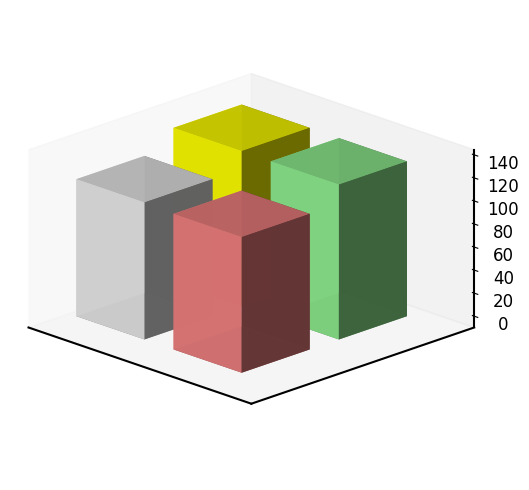

In [ ]:
yc_company_ratio = [[
    qdrant_to_yc_company_cnt["opportunity_zone"]/qdrant_to_task_cnt["opportunity_zone"],
    qdrant_to_yc_company_cnt["green_light_zone"]/qdrant_to_task_cnt["green_light_zone"]],[
    qdrant_to_yc_company_cnt["low_priority_zone"]/qdrant_to_task_cnt["low_priority_zone"],
    qdrant_to_yc_company_cnt["red_light_zone"]/qdrant_to_task_cnt["red_light_zone"]]]

plot_quadrant_bars_2d_aligned(yc_company_ratio, azim=-45)

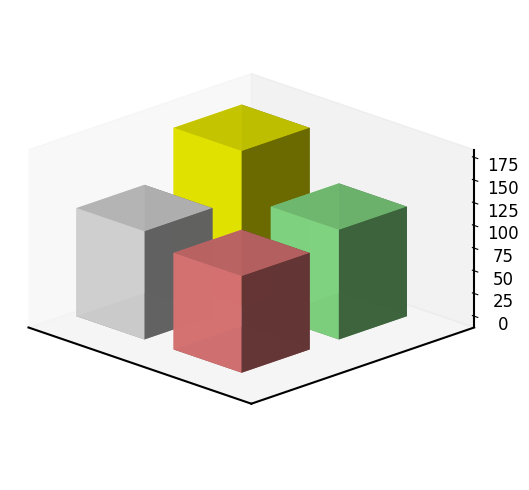

In [ ]:
paper_ratio = [[
    qdrant_to_paper_cnt["opportunity_zone"]/qdrant_to_task_cnt["opportunity_zone"],
    qdrant_to_paper_cnt["green_light_zone"]/qdrant_to_task_cnt["green_light_zone"]],[
    qdrant_to_paper_cnt["low_priority_zone"]/qdrant_to_task_cnt["low_priority_zone"],
    qdrant_to_paper_cnt["red_light_zone"]/qdrant_to_task_cnt["red_light_zone"]]]

plot_quadrant_bars_2d_aligned(paper_ratio, azim=-45)

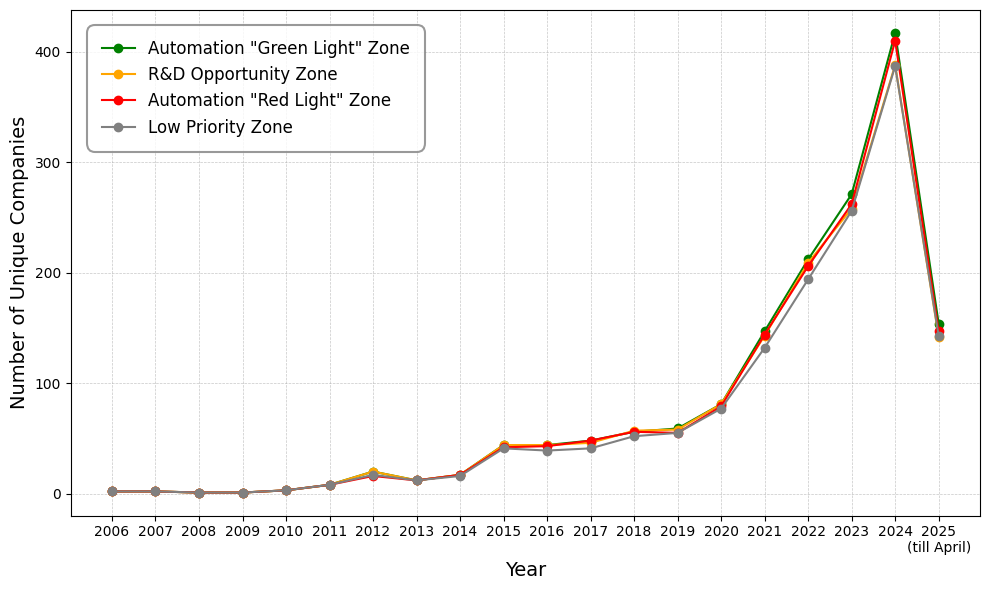

In [38]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

yc_company_to_year = pd.read_csv("../external_data/company_to_year_mapping.csv")
yc_expanded = (
    yc_company
      .assign(company=lambda df: df["company"].str.split(";"))
      .explode("company")
)
yc_expanded["company"] = yc_expanded["company"].str.strip()
yc_expanded["quadrant"] = yc_expanded["task"].map(task_to_qdrant_mapping)

df = (
    yc_expanded
      .merge(yc_company_to_year, on="company", how="left")
      .dropna(subset=["year", "quadrant"])     # drop any unmatched
)

trend = (
    df.groupby(["year", "quadrant"])["company"]
      .nunique()
      .reset_index(name="n_companies")
)

trend_pivot = (
    trend.pivot(index="year", columns="quadrant", values="n_companies")
         .fillna(0)
         .sort_index()
)

color_map = {
    "green_light_zone":   "green",
    "opportunity_zone":   "orange",
    "red_light_zone":     "red",
    "low_priority_zone":  "gray",
}

label_map = {
    "green_light_zone":   "Automation \"Green Light\" Zone",
    "opportunity_zone":   "R&D Opportunity Zone",
    "red_light_zone":     "Automation \"Red Light\" Zone",
    "low_priority_zone":  "Low Priority Zone",
}

# --- plot ---
fig, ax = plt.subplots(figsize=(10, 6))

for quad in ["green_light_zone", "opportunity_zone", "red_light_zone", "low_priority_zone"]:
    if quad in trend_pivot.columns:
        ax.plot(
            trend_pivot.index,
            trend_pivot[quad],
            marker="o",
            label=label_map[quad],
            color=color_map[quad]
        )

ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Unique Companies", fontsize=14)

# --- custom x-tick labels, relabel 2025 to include “(till April)” ---
years = trend_pivot.index.astype(int)
ax.set_xticks(years)
ax.set_xticklabels([
    str(y) if y < years.max() else f"{y}\n(till April)"
    for y in years
])
ax.grid(True, ls="--", lw=.5, alpha=.7)

# --- styled legend ---
legend = ax.legend(
    loc="lower right",
    bbox_to_anchor=(0.39, 0.72),
    prop=fm.FontProperties(size=12),
    frameon=True
)
frame = legend.get_frame()
frame.set_facecolor("white")
frame.set_edgecolor("gray")
frame.set_linewidth(1.5)
frame.set_boxstyle("round,pad=0.5")
# for text in legend.get_texts():
#     text.set_fontweight("bold")

plt.tight_layout()
plt.savefig("../local/yc_company_trend.png", dpi=300)